# Methods
1. Intrinsic
2. Filter
3. Wrapper

# Intrinsic
- feature selection embedded in the training process
- from the set of all features
    - select a subset of features, train the model, evaluate the performance
    - select another subset of features,  train the model, evaluate the performance
    - the best subset of features is decide by the performance of the ML algorithm
    - mathematically, no. of possible iterations = $2^{n\_features}$
- for instance, DTs (and other DT based ensembles)
    - since DTs use features to split, those features that aren't used in any DT to split $\rightarrow$ no impact on the target $\rightarrow$ essentially not selected
    - **only this action of DTs is intrinsically selecting features**, the **feature importance** based selection is still a filter method
- Another example, L1-regularisation i.e. Lasso Regression
    - for a large enough $\lambda$, all coefficients are 0
    - for a moderate enough $\lambda$, all coefficients that are small-valued are made 0
- Model Dependent, and the pool of algos that intrinsically select features is limited

# Filter
1. first finalize the best subset of features, then train the model
2. selection process only happens once, hence this process is naturally fast

## Uni-variate analysis
1. linear correlation between target and features, those whose correlation coefficient pass a threshold

### Cons
1. what if important signals aren't linearly correlated, but non-linearly correlated with the target?
2. doesn't incorporate feature-interactions that could affect the target.
    - as in, the interplay of 2 features (their combination, ordered pair in some sense) could be a stronger signal than them being considered individually, and suppose only 1 of them turned out to be linearly correlated enough with the target to get selected but the other didn't

## Feature-importance based
1. this is still model-based, but tree based models could provide some baseline
2. use feature importance from a tree based models and only use those that turn out to be important to train some other model.

### Pros
1. provides a good enough baseline
2. helpful especially when you've too many features
3. 

### Cons
1. no guarantee, just a thumb rule
2. again, specific to tree-based models, no generality
3. fails at redundancy handling, i.e. multiple highly correlated features (would assign them similar feature importance values, and if that's high enough both get selected, but both shouldn't be selected, only one should be as only one of them carries the important signal)
4. doesn't incorporate feature-interactions that could affect the target.
    1. although the tree based model that was used in its structure and algorithm does acknowledge feature interactions (f1 used to split at X, f2 used to split inside f1's subtree), the feature importance score are computed when independently considering each feature, because its based on how much information gain (decrease in impurity)  did it cause *by itself*.

# Wrapper

## Recursive Feature Elimination
1. start with a set of all features
2. train model, evaluate performance, sort features based on feature importance
3. eliminate the least important feature
4. repeat steps 2-3 till no significant improvement, or `min_features` threshold hit

## Stepwise feature selection
1. more suited for linear models, not discussed as of now
<font color="red">remaining!!</font>

# Permutation Importance
- literally permute the values of a feature amongst the training samples
- if the feature is important, the resulting model will be garbage
- if the feature was not so important, minor performance change

# SHAP values
1. Lloyd Shapley
2. [Best Playlist on SHAP values](https://www.youtube.com/watch?v=UJeu29wq7d0&list=PLqDyyww9y-1SJgMw92x90qPYpHgahDLIK&index=3)
3. Game theory context
    1. say we have a competition, with prices for the 1st($10k), 2nd($7.5k) and 3rd($5k) place
    2. people can enrol individually or as a team (coalition)
    3. say there are 2 friends, 1 and 2, s.t.
        1. if they form a coalition, $C_{1,2}$, they earn the first price = $10k
        2. if they enter individually, $C_1$ earns $7.5K, $C_2$ earns $5K
        3. obviously if none of them register, amongst the two the price earned = $0$ (empty coalition, i.e. $C_0$)
        3. they want to know who is contributing more , so that they can split the first price fairly, rather than evenly dividing it.
    4. if they are to calculate the **Expected marginal contribution**
        1. marginal contribution by 1 = $\dfrac{\left(C_{1,2} - C_{2}\right) + \left(C_{1} - C_{0}\right) }{2} = \frac{5k + 7.5k}{2} = \$6.25k$
        2. marginal contribution by 1 = $\dfrac{\left(C_{1,2} - C_{2}\right) + \left(C_{1} - C_{0}\right) }{2} = \frac{5k + 7.5k}{2} = \$6.25k$
4. SHAP value (contribution by $i^{th}$ feature on the model output)
5. [go through this chat once as well](https://chatgpt.com/share/679a789c-8434-800d-b498-80265189ddfd)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

import shap
shap.initjs()

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [73]:
X, y = make_regression(n_samples=1000, n_features=10, n_informative=4, noise=0.2, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

dtr = DecisionTreeRegressor(max_depth=10, random_state=42)
dtr.fit(x_train, y_train)

print(f"R^2 = {dtr.score(x_test, y_test)}")

R^2 = 0.887894914116386


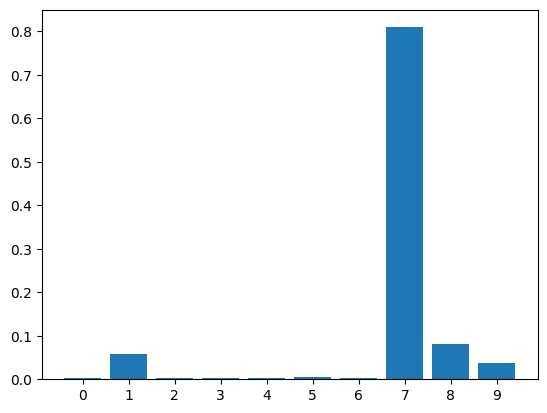

In [74]:
plt.bar(range(dtr.n_features_in_), dtr.feature_importances_)
plt.xticks(range(dtr.n_features_in_))
plt.show()

## SHAP on `x_train`

In [75]:
explainer = shap.Explainer(dtr)
shap_values = explainer(x_train)

print(np.shape(shap_values.values))

(750, 10)


- Shap values exist for each sample
- this is how they tell us for each sample which feature was the most impactful, and which were the least impactful ones.
- E[f(X)] = average value of predictand across all training samples (since `x_train` was given to the shap explainer)
- each value (+ or -) represents how much that feature contributed to in predicting the value for that sample
    - feature 7 alone cause the prediction to increase by +14.33 from the expected value of 0.75
    - feature 8 however, brought it down by -3.8, and similar goes the explanation for other features

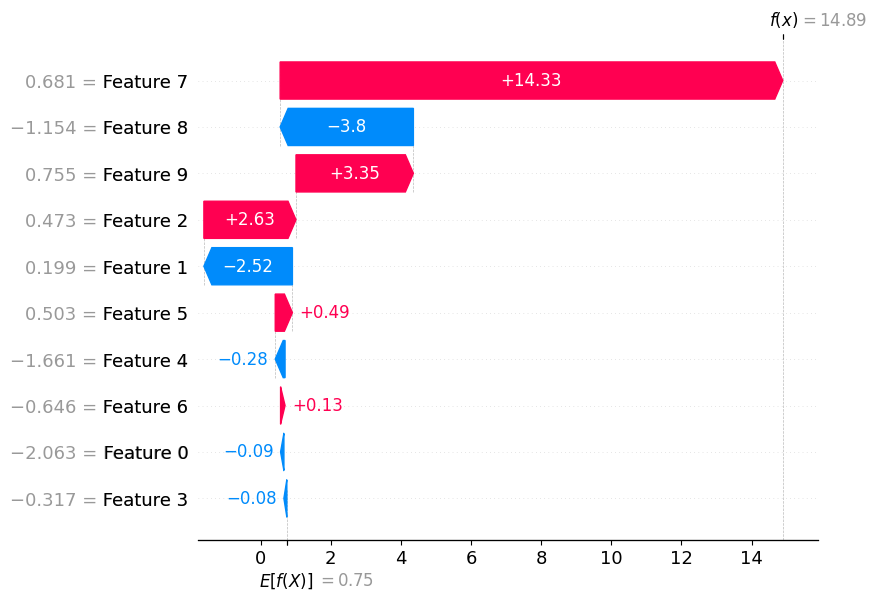

In [76]:
shap.plots.waterfall(shap_values[0])

In [15]:
# condensed waterfall plot
shap.plots.force(shap_values[0])

In [18]:
# condensed waterfall plot
shap.plots.force(shap_values[1])

- The below stacked force plot is formed by flipping the above force plot by 90 degrees counterclockwise and then horizontally stacking them
- That's why, when you order it using "original sample ordering" you will see that the first from the left is the first sample, and its "red" (push to +) region is larger than its "blue" region (push to -)
    - similarly, for the 2nd sample, since its prediction is -ve, the blue region will be larger than the red region

In [17]:
# condensed waterfall plot
shap.plots.force(shap_values[0:2])

In the stacked plot below
1. select Feature 7
    1. as it increases (from -2.5 to 3), the f(x) also increases
    2. 

In [16]:
# stacked force plot
shap.plots.force(shap_values[:100])

Feature importance via SHAP
- for each sample, each feature has some real number shap value
    - across all samples, take the absolute shap value for each feature, then calculate the mean
    - hence absolute mean  SHAP value of a feature = feature importance via SHAP

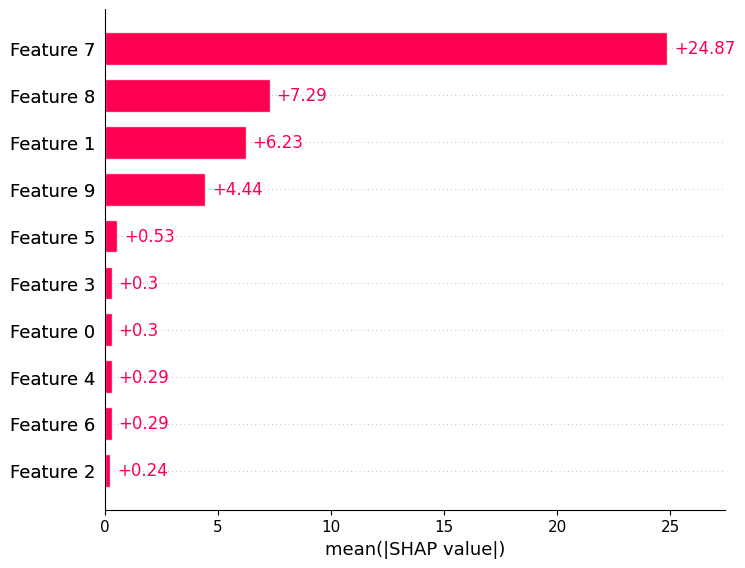

In [19]:
shap.plots.bar(shap_values)

Beeswarm plot
- to be read as bee-swarm
- as seen below
    - high feature 7 $\rightarrow$ high f(x)
    - the same is the trend, albeit less strong/less powerful for features 8,1,9

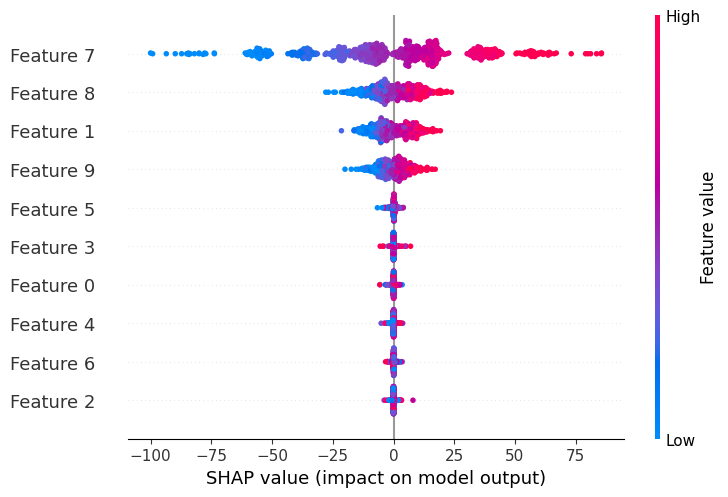

In [20]:
shap.plots.beeswarm(shap_values)

Dependence plots
- useful to explore if a feature has a *non-linear* relation with the dependent variable

In [40]:
# scatter plot needs the shap_values.feature_names attribute initialized to some non-empty , str-only list
shap_values.feature_names = [f'Feature {i}' for i in range(10)]

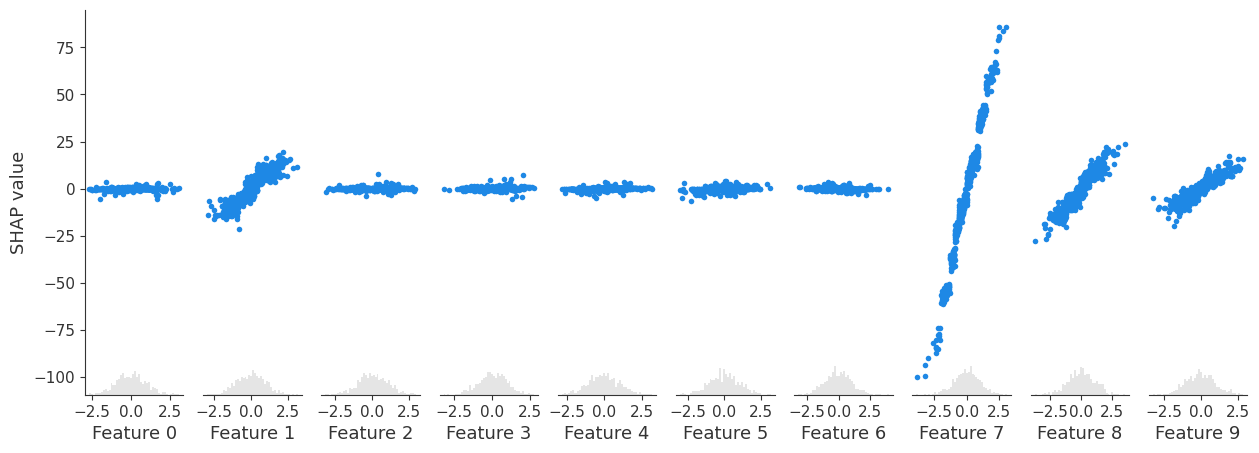

In [47]:
shap.plots.scatter(shap_values[:, :])

## SHAP on `x_test`

In [48]:
explainer = shap.Explainer(dtr)
shap_values = explainer(x_test)

print(np.shape(shap_values.values))

(250, 10)


- Shap values exist for each sample
- this is how they tell us for each sample which feature was the most impactful, and which were the least impactful ones.
- E[f(X)] = average value of predictand across all training samples (since `x_train` was given to the shap explainer)
- each value (+ or -) represents how much that feature contributed to in predicting the value for that sample
    - feature 7 alone cause the prediction to increase by +14.33 from the expected value of 0.75
    - feature 8 however, brought it down by -3.8, and similar goes the explanation for other features

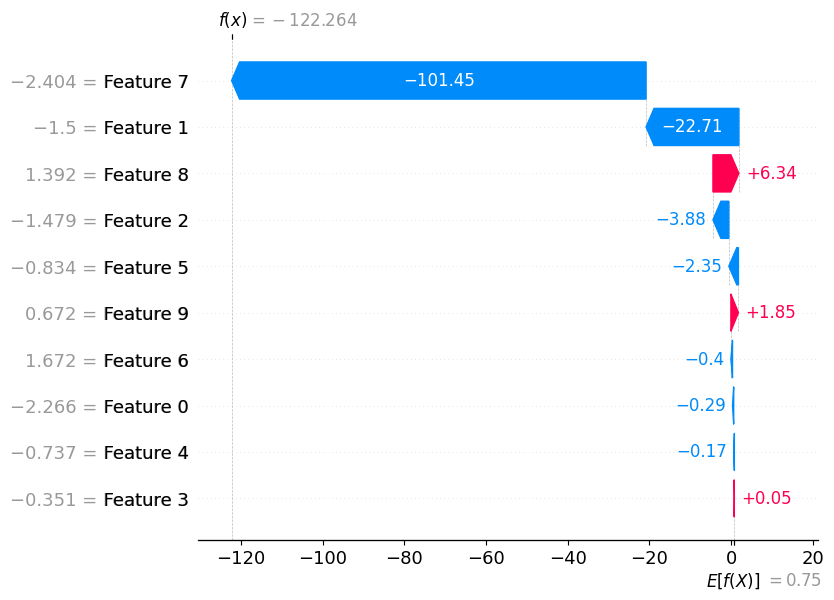

In [49]:
shap.plots.waterfall(shap_values[0])

In [50]:
# condensed waterfall plot
shap.plots.force(shap_values[0])

In [51]:
# condensed waterfall plot
shap.plots.force(shap_values[1])

- The below stacked force plot is formed by flipping the above force plot by 90 degrees counterclockwise and then horizontally stacking them
- That's why, when you order it using "original sample ordering" you will see that the first from the left is the first sample, and its "red" (push to +) region is larger than its "blue" region (push to -)
    - similarly, for the 2nd sample, since its prediction is -ve, the blue region will be larger than the red region

In [52]:
# condensed waterfall plot
shap.plots.force(shap_values[0:2])

In the stacked plot below
1. select Feature 7
    1. as it increases (from -2.5 to 3), the f(x) also increases
    2. 

In [53]:
# stacked force plot
shap.plots.force(shap_values[:100])

Feature importance via SHAP
- for each sample, each feature has some real number shap value
    - across all samples, take the absolute shap value for each feature, then calculate the mean
    - hence absolute mean  SHAP value of a feature = feature importance via SHAP

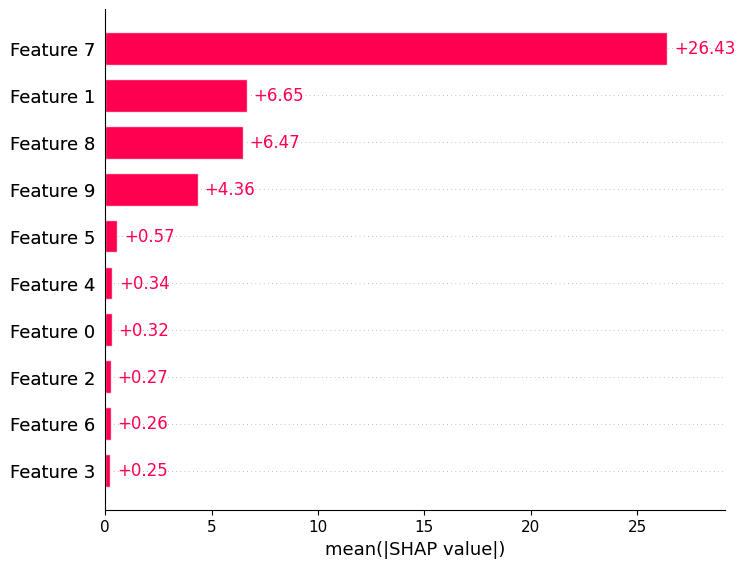

In [54]:
shap.plots.bar(shap_values)

Beeswarm plot
- to be read as bee-swarm
- as seen below
    - high feature 7 $\rightarrow$ high f(x)
    - the same is the trend, albeit less strong/less powerful for features 8,1,9

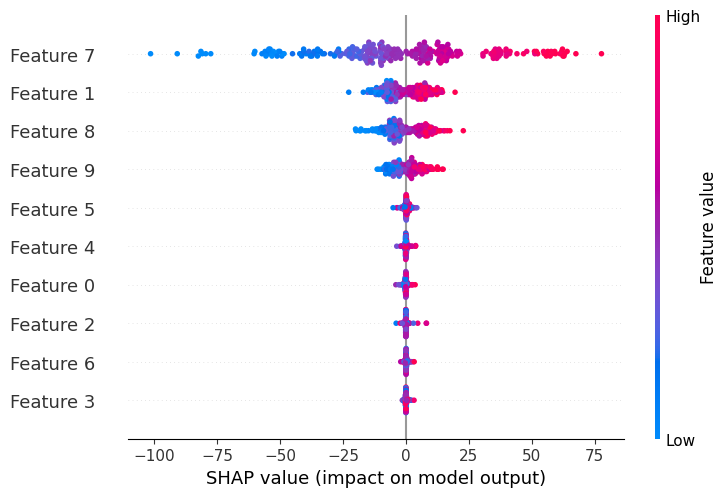

In [55]:
shap.plots.beeswarm(shap_values)

Dependence plots
- useful to explore if a feature has a *non-linear* relation with the dependent variable

In [56]:
# scatter plot needs the shap_values.feature_names attribute initialized to some non-empty , str-only list
shap_values.feature_names = [f'Feature {i}' for i in range(10)]

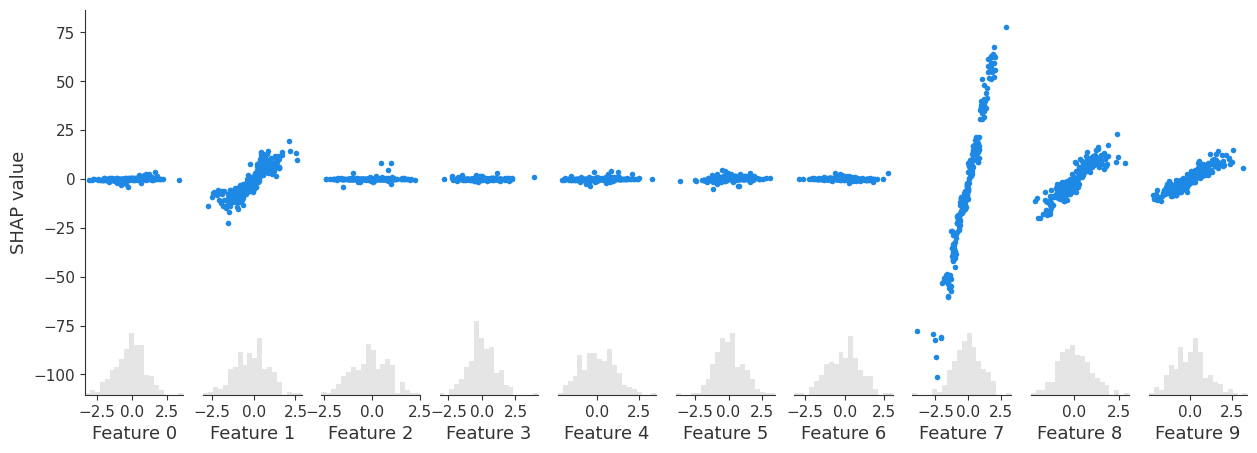

In [57]:
shap.plots.scatter(shap_values[:, :])

SHAP feature-interaction values

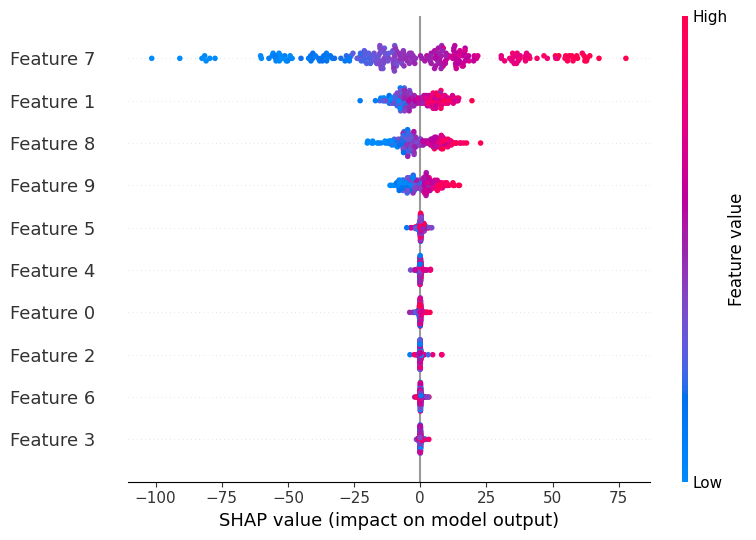

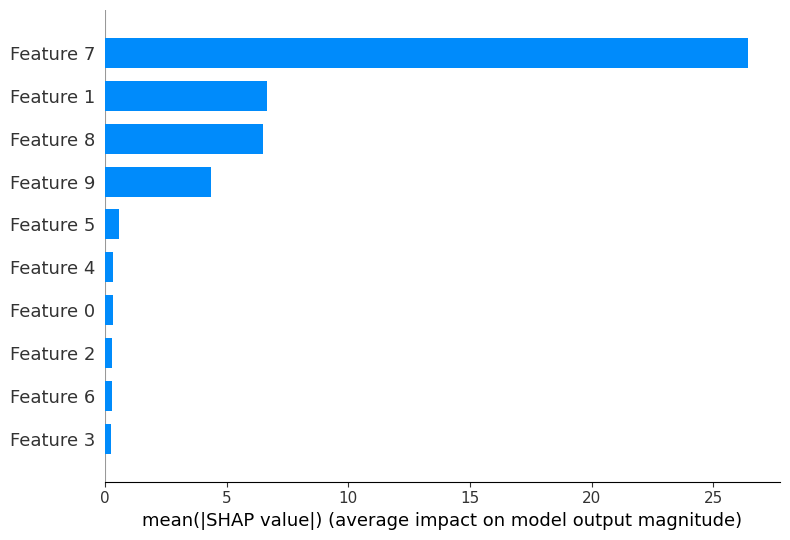

In [58]:
# Visualize the SHAP interaction values for Random Forest
shap.summary_plot(shap_values, x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar")

Feature interaction plot

In [60]:
shap.dependence_plot(0, shap_values[0], x_test)

IndexError: tuple index out of range

# Pipelinize this

If you're sitting there manually tweaking feature counts like a caveman, you’re doing it wrong. In an end-to-end ML pipeline, you automate this experimentation. \
You set up:

1. Feature selection sweeps – Instead of hard-cutting at 50, run experiments varying the number dynamically (e.g., 50, 60, 70, top N + bottom M, etc.).
2. Hyperparameter tuning – Integrate feature selection with model tuning in a grid or Bayesian search (hello, Optuna).
3. Meta-learning / AutoML – Stop playing feature whack-a-mole and let an automated system learn which feature subsets perform best.
4. SHAP-guided re-selection – Use SHAP iteratively to refine feature selection before final model training, rather than as a post-mortem regret session.